<center><h1>PyTorch Intro</h1></center>

<h2>Training a Classifier</h2>

In this notebook we will train a classifier that will classify images of the CIFAR-10 dataset. This dataset contains 32x32 pixel, RGB(3-channel) pictures that are labeled as ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’ or ‘truck’.

Initially, we will import the libraries that we will use in order to load the data.

In [46]:
import torch
import torchvision     #Contains the necessary datasets
import torchvision.transforms as transforms #It is used to apply simple preprocessing steps into the dataset


<h2>Preprocessing</h2>

Firstly, we will define our transformation which does 2 steps using <code>Compose</code> method. Firstly, it will convert the pictures into tensors. Secondly, because the pictures are in range $[0,1]$ we will normalize them to range $[-1,1]$

In [84]:
# Defining transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Providing mean and std of each channel 
                                                           # and does (pxl - mean) / std
])

# Loading the dataset
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, 
                                       download=True, transform=transform)

# Creating a DataLoader for that dataset.
# DataLoader is an iteratable that will help us train
# our classifier and get our batches automatically

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                        shuffle=True, num_workers=2)

# Doing the same to create a test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



Now we will print some images


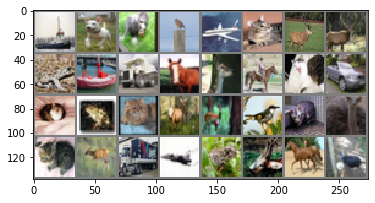

 ship   dog   dog  bird


In [85]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)

# get 5th batch

for _ in range(5):
    images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


<h2> Creating our network </h2>

Now we will create our convolutional neural network.

In order to create a neural network in PyTorch we should define a class that inherits <code>nn.Module</code> class and implements the contructor and the forward method.

In [101]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 1st arg = input channels, 2nd arg = output channels
        # 3rd arg = kernel size
        self.conv1 = nn.Conv2d(3, 16, (3,3))
        
        # There we define only kernel size
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(16, 32, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        
        # Now we will have the fully connected layers
        # Because in PyTorch there is not any flatten layer
        # we should compute the number of the input features 
        # of the flatten layer ourselves or do some computations.
        
        self.fc1 = nn.Linear(32 * 6 * 6, 270)
        self.fc2 = nn.Linear(270, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)
    
    # x is the input batch
    # just passes x through networks operations
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        x = x.view(-1, 32 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        
        return x

net = Net()

#in order to use cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=270, bias=True)
  (fc2): Linear(in_features=270, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)


After creating our network we should define our loss function and optimizer.


In [102]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

<h2>Training the Network</h2>

In this section we will just iterate through the data loader and we will incrementally train our network

In [103]:
num_epochs = 10

for i in range(num_epochs):
    running_loss = 0
    
    for curr_batch in trainloader:
        vectors, labels = curr_batch[0].to(device), curr_batch[1].to(device)
        
        optimizer.zero_grad() # we will just make zero the gradients of optimizer
        
        outputs = net.forward(vectors) # we will do the forward pass for the current batch
        
        # Computing the loss
        loss    = criterion(outputs, labels)
        
        #Doing backward pass
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
    
    print("Epoch", i, " Loss:", running_loss)
    
# In order to save our model
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

Epoch 0  Loss: 2.1780874729156494
Epoch 1  Loss: 2.2360360622406006
Epoch 2  Loss: 2.0688319206237793
Epoch 3  Loss: 2.021897077560425
Epoch 4  Loss: 2.098893404006958
Epoch 5  Loss: 2.116778612136841
Epoch 6  Loss: 1.973324179649353
Epoch 7  Loss: 1.9308443069458008
Epoch 8  Loss: 2.0329465866088867
Epoch 9  Loss: 1.7963060140609741


 <h2>Testing the network</h2>
 
 We should just loop through the train set and get the network's outputs.

In [104]:
correct_preds = 0
all_preds     = 0

for curr_batch in testloader:
    vectors, labels = curr_batch[0].to(device), curr_batch[1].to(device)
    
    predictions = torch.argmax(net(vectors), dim=1)
    
    all_preds     += predictions.size(0)
    correct_preds += (predictions == labels).sum().item()

print("Accuracy is", (correct_preds / all_preds) * 100, "per cent")

Accuracy is 52.32 per cent


<h2>Conclusion</h2>

I created a fully-working classifier of the CIFAR10 dataset. However, having accuracy of 50% we can clearly see that we have space for improvement to build na even better classifier, but we still have a pretty good classifier. Now future direction of this problem is to exploit hyperparameter tuning techniques which I will see on other day.